In [1]:
#STEPS NECESSARY FOR PCA/UMAP

In [2]:
import pandas as pd
import numpy as np
import os

In [25]:
# --- IMPORTANT: YOU MUST CHANGE THESE FILE PATHS ---
# Path to your final combined CSV file (e.g., 'Combined_ArrangedTable_and_GeneExpression_Cleaned.csv')
input_combined_file_path = 'C:/Users/Admin/Desktop/ArrangedTable.csv'

# Desired name for the output file containing wide gene expression data with subtypes
output_wide_data_file_name = 'Wide Data with labels.csv'

# --- OPTIONAL: If you want to save the output file to your desktop ---
desktop_path = 'C:/Users/Admin/Desktop' 
output_full_path = os.path.join(desktop_path, output_wide_data_file_name)

# --- Encoding fallback (use the same encoding you used to create the combined file) ---
encoding_to_use = 'utf-8' # Or 'latin1' or 'cp1252'

# Define the columns we need
SUBTYPE_COLUMN = 'Subtype'
GENE_EXPRESSION_VALUE_COLUMN = 'fpkm_uq_unstranded'
GENE_NAME_COLUMN = 'gene_name'
 # This is the Sample_ID from TCGA-BLCA
PATIENT_ID_COLUMN = 'PATIENT_ID'

try:
    # 1. Load the final combined CSV file
    df_combined = pd.read_csv(input_combined_file_path, encoding=encoding_to_use)
    print(f"Successfully loaded '{input_combined_file_path}'. Original shape: {df_combined.shape}")
    print(f"Columns in loaded DataFrame: {df_combined.columns.tolist()}")

    # --- Verify necessary columns exist ---
    required_cols_for_pivot = [PATIENT_ID_COLUMN, GENE_NAME_COLUMN, GENE_EXPRESSION_VALUE_COLUMN, SUBTYPE_COLUMN]
    for col in required_cols_for_pivot:
        if col not in df_combined.columns:
            raise ValueError(f"Error: Required column '{col}' not found in the combined file. Please check column names.")

    # 2. Pivot the gene expression data to wide format
    # This will create a DataFrame where rows are samples and columns are genes.
    print(f"\nPivoting gene expression data using '{GENE_NAME_COLUMN}' as columns and '{GENE_EXPRESSION_VALUE_COLUMN}' as values...")
    df_gene_expression_wide = df_combined.pivot_table(
        index=PATIENT_ID_COLUMN,
        columns=GENE_NAME_COLUMN,
        values=GENE_EXPRESSION_VALUE_COLUMN
    )

    print(f"Shape of pivoted gene expression data: {df_gene_expression_wide.shape}")
    print("First 5 rows and columns of pivoted data (samples as rows, genes as columns):")
    # Displaying head and sample of columns to show structure
    print(df_gene_expression_wide.iloc[:5, :5].to_string()) # Show first 5 rows and first 5 columns


    # 3. Extract and align the Subtype subtype labels
    # We need to get unique Sample_ID to Subtype mapping from the original combined df
    # since Sample_ID is repeated for each gene.
    df_subtypes = df_combined[[PATIENT_ID_COLUMN, SUBTYPE_COLUMN]].drop_duplicates().set_index(PATIENT_ID_COLUMN)

    # Ensure the subtypes are aligned with the pivoted gene expression DataFrame's index
    # This ensures we only keep samples that have both gene expression data and subtype labels.
    df_final_ml_data = df_gene_expression_wide.merge(
        df_subtypes,
        left_index=True,
        right_index=True,
        how='inner' # Use inner merge to ensure only samples with both data types are kept
    )

    # Move the subtype column to be the first column for convenience
    cols = [SUBTYPE_COLUMN] + [col for col in df_final_ml_data.columns if col != SUBTYPE_COLUMN]
    df_final_ml_data = df_final_ml_data[cols]


    # 4. Handle NaNs in pivoted data (if any genes had missing values for some samples)
    # Common strategies: fill with 0, or fill with mean/median of the gene.
    # For now, let's fill with 0. You can change this if you prefer mean/median.
    print(f"\nHandling NaN values in gene expression data. Initial NaNs: {df_final_ml_data.isnull().sum().sum()}")
    df_final_ml_data.fillna(0, inplace=True)
    print(f"NaNs after filling with 0: {df_final_ml_data.isnull().sum().sum()}")
    initial_rows = df_final_ml_data.shape[0]
    
    


    print(f"\nFinal ML-ready DataFrame shape: {df_final_ml_data.shape}")
    print("First 5 rows of the ML-ready DataFrame (Subtype + Gene Expression):")
    print(df_final_ml_data.iloc[:5, :5].to_string()) # Display first 5 rows and first 5 columns including subtype

    # 5. Save the prepared wide data with subtypes
    df_final_ml_data.to_csv(output_full_path, index=True) # Keep index as Sample_ID
    print(f"\nML-ready data successfully saved to: '{output_full_path}'")
    print("This file contains samples as rows, genes as columns, and the 'Subtype' subtype as the first column.")


except FileNotFoundError as e:
    print(f"Error: The input file was not found at {input_combined_file_path}. Please check the path. {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'C:/Users/Admin/Desktop/ArrangedTable.csv'. Original shape: (18198000, 10)
Columns in loaded DataFrame: ['Sample_ID', 'gene_name', 'gene_type', 'gene_id', 'fpkm_uq_unstranded', 'SAMPLE_ID', 'PATIENT_ID', 'Subtype', 'AR_score', 'File_name']

Pivoting gene expression data using 'gene_name' as columns and 'fpkm_uq_unstranded' as values...
Shape of pivoted gene expression data: (270, 59427)
First 5 rows and columns of pivoted data (samples as rows, genes as columns):
gene_name      5S_rRNA  5_8S_rRNA       7SK    A1BG  A1BG-AS1
PATIENT_ID                                                   
TCGA-2A-A8VL  0.120800        0.0  0.000000  0.0324    0.1150
TCGA-2A-A8VO  0.031400        0.0  0.016114  0.0084    0.0598
TCGA-2A-A8VT  0.057556        0.0  0.000000  0.0046    0.0814
TCGA-2A-A8W1  0.067044        0.0  0.000000  0.0000    0.0000
TCGA-2A-A8W3  0.076478        0.0  0.000000  0.0154    0.0789

Handling NaN values in gene expression data. Initial NaNs: 0
NaNs after filli

In [19]:
a = pd.read_csv("C:/Users/Admin/Desktop/Wide Data with labels.csv")
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Columns: 59429 entries, PATIENT_ID to snoZ196
dtypes: float64(59427), object(2)
memory usage: 122.0+ MB


Successfully loaded 'C:/Users/Admin/Desktop/Wide Data with labels.csv'. Shape: (269, 59429)
Set 'PATIENT_ID' as DataFrame index.

Shape of features (X): (269, 59427)
Shape of target (y): (269,)
Subtype Subtypes unique values: ['1-ERG' '8-other' '2-ETV1' '6-FOXA1' '3-ETV4' '5-SPOP' '7-IDH1' '4-FLI1']
Subtype Subtypes distribution:
Subtype
1-ERG      124
8-other     71
5-SPOP      33
2-ETV1      21
3-ETV4      12
6-FOXA1      5
4-FLI1       2
7-IDH1       1
Name: count, dtype: int64

Scaling gene expression data using StandardScaler...
Scaling complete.

Performing PCA with 2 components...
Shape of PCA result DataFrame: (269, 3)
First 5 rows of PCA results with Subtype Subtype:
                    PC1        PC2 Subtype_Subtype
PATIENT_ID                                        
TCGA-2A-A8VL  -8.560099  38.250426           1-ERG
TCGA-2A-A8VO  -6.530964  62.902231         8-other
TCGA-2A-A8VT   7.332216  22.705350           1-ERG
TCGA-2A-A8W1 -27.364238  58.857509          2-ETV1
TCGA-2A-A

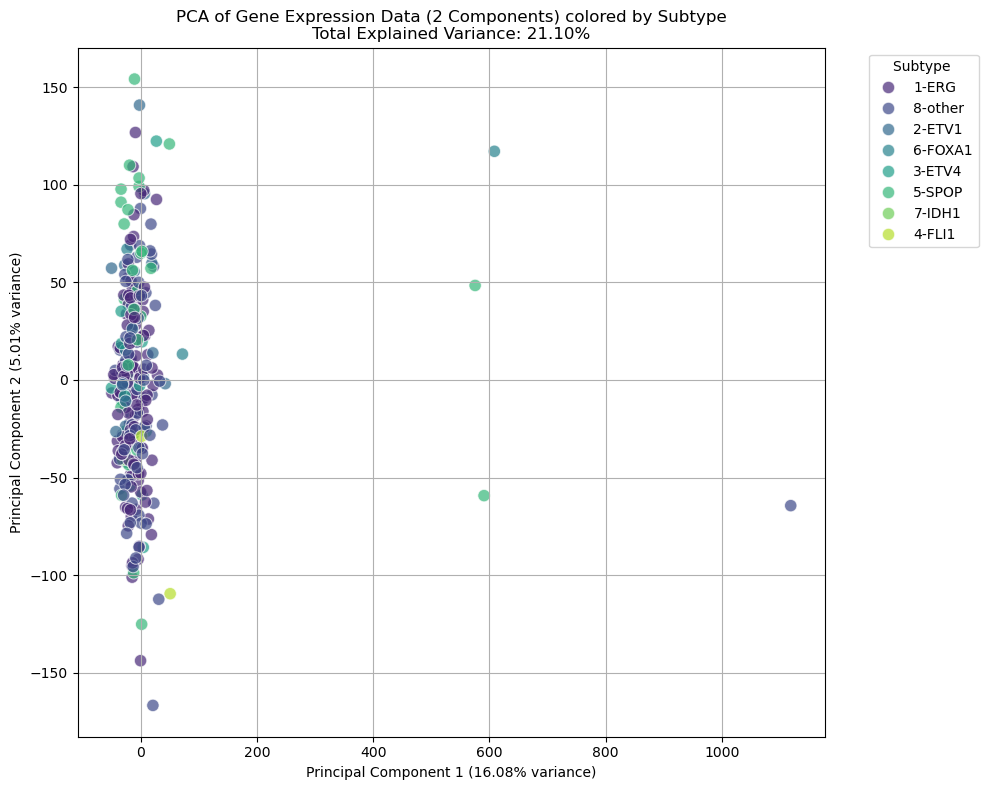

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- IMPORTANT: Path to your wide data file ---
input_wide_data_path = 'C:/Users/Admin/Desktop/Wide Data with labels.csv' # This file is uploaded in the current session


try:
    # 1. Load the Wide Data with labels.csv file
    df_wide_data = pd.read_csv(input_wide_data_path)
    print(f"Successfully loaded '{input_wide_data_path}'. Shape: {df_wide_data.shape}")

    # Ensure PATIENT_ID is set as index if it's not already
    if 'PATIENT_ID' in df_wide_data.columns:
        df_wide_data.set_index('PATIENT_ID', inplace=True)
        print("Set 'PATIENT_ID' as DataFrame index.")

    # 2. Separate Features (X) and Target (y)
    # X will be all gene expression columns
    # y will be the 'Subtype' subtype column
    if 'Subtype' not in df_wide_data.columns:
        raise ValueError("Error: 'Subtype' column not found in the loaded DataFrame. Please ensure it exists.")

    X = df_wide_data.drop(columns=['Subtype']) # Features (genes)
    y = df_wide_data['Subtype']             # Target (Subtype subtypes)

    print(f"\nShape of features (X): {X.shape}")
    print(f"Shape of target (y): {y.shape}")
    print(f"Subtype Subtypes unique values: {y.unique()}")
    print(f"Subtype Subtypes distribution:\n{y.value_counts()}")


    # 3. Data Preprocessing (Scaling)
    # PCA is sensitive to scale, so we normalize the gene expression data.
    print("\nScaling gene expression data using StandardScaler...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    print("Scaling complete.")

    # 4. Perform PCA
    # Let's reduce to 2 principal components for 2D visualization
    n_components_pca = 2
    print(f"\nPerforming PCA with {n_components_pca} components...")
    pca = PCA(n_components=n_components_pca)
    principal_components = pca.fit_transform(X_scaled)

    # Create a DataFrame for the principal components
    pca_df = pd.DataFrame(data=principal_components,
                          columns=[f'PC{i+1}' for i in range(n_components_pca)],
                          index=X.index)

    # Add the Subtype subtype labels to the PCA DataFrame for plotting
    pca_df['Subtype_Subtype'] = y

    print(f"Shape of PCA result DataFrame: {pca_df.shape}")
    print("First 5 rows of PCA results with Subtype Subtype:")
    print(pca_df.head().to_string())

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"\nExplained variance ratio by PC1: {explained_variance_ratio[0]:.2f}")
    print(f"Explained variance ratio by PC2: {explained_variance_ratio[1]:.2f}")
    print(f"Total explained variance by {n_components_pca} PCs: {sum(explained_variance_ratio):.2f}")


    # 5. Visualize PCA results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Subtype_Subtype', data=pca_df,
                    palette='viridis', s=80, alpha=0.7)
    plt.title(f'PCA of Gene Expression Data (2 Components) colored by Subtype\nTotal Explained Variance: {sum(explained_variance_ratio)*100:.2f}%')
    plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.2f}% variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.2f}% variance)')
    plt.legend(title='Subtype ', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_wide_data_path}' was not found. Please ensure it's in the same directory as the script.")
except ValueError as e:
    print(f"Data Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Performing UMAP with 2 components...


c:\Users\Admin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of UMAP result DataFrame: (269, 3)
First 5 rows of UMAP results with Subtype:
                 UMAP_1     UMAP_2 Subtype_Subtype
PATIENT_ID                                        
TCGA-2A-A8VL  18.347834 -10.638028           1-ERG
TCGA-2A-A8VO  17.946171  -8.612817         8-other
TCGA-2A-A8VT  15.947040  -8.822752           1-ERG
TCGA-2A-A8W1  17.970016  -9.240062          2-ETV1
TCGA-2A-A8W3  16.635675 -10.025571          2-ETV1


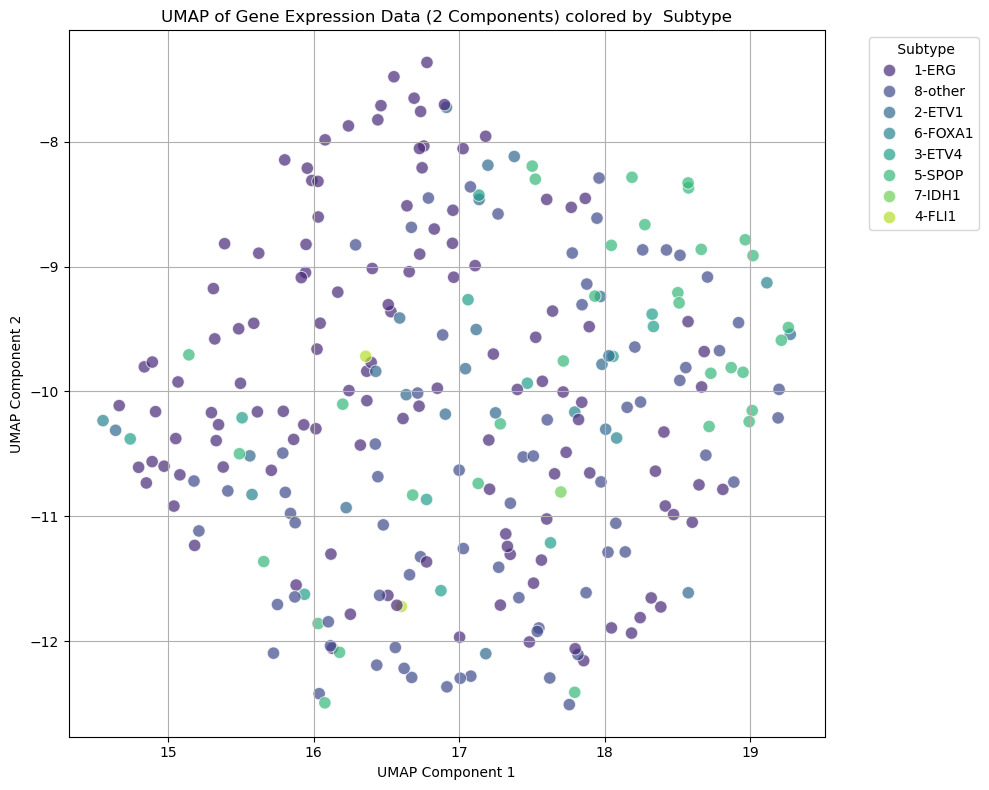

In [21]:
#Perform UMAP (Uniform Manifold Approxiamtion and Projection)

import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import os


# --- IMPORTANT: Path to your wide data file ---
input_wide_data_path = 'C:/Users/Admin/Desktop/Wide Data with labels.csv' # This file is uploaded in the current session


try:
    # 1. Load the Wide Data with labels.csv file (if not already in memory)
    # This step is repeated to ensure the code is runnable independently if needed.
    df_wide_data = pd.read_csv(input_wide_data_path)
    if 'PATIENT_ID' in df_wide_data.columns:
        df_wide_data.set_index('PATIENT_ID', inplace=True)
    
    X = df_wide_data.drop(columns=['Subtype']) # Features (genes)
    y = df_wide_data['Subtype']             
    # Target (Subtype subtypes)

    # Scale the data (essential for UMAP as well, similar to PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) # Keep as DataFrame for clarity


    # 2. Perform UMAP
    # Let's reduce to 2 components for 2D visualization
    n_components_umap = 2
    print(f"\nPerforming UMAP with {n_components_umap} components...")

    # UMAP parameters can be tuned. n_neighbors and min_dist are common ones.
    # default n_neighbors=15, min_dist=0.1
    # You might experiment with these:
    # UMAP (n_neighbors=10, min_dist=0.3, random_state=42) # Example of different parameters
    reducer = umap.UMAP(n_components=n_components_umap, random_state=42) # random_state for reproducibility
    
    umap_embedding = reducer.fit_transform(X_scaled)

    # Create a DataFrame for the UMAP embedding
    umap_df = pd.DataFrame(data=umap_embedding,
                           columns=[f'UMAP_1', f'UMAP_2'],
                           index=X.index)

    # Add the Subtype subtype labels to the UMAP DataFrame for plotting
    umap_df['Subtype_Subtype'] = y

    print(f"Shape of UMAP result DataFrame: {umap_df.shape}")
    print("First 5 rows of UMAP results with Subtype:")
    print(umap_df.head().to_string())

    # 3. Visualize UMAP results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='Subtype_Subtype', data=umap_df,
                    palette='viridis', s=80, alpha=0.7)
    plt.title('UMAP of Gene Expression Data (2 Components) colored by  Subtype')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend(title=' Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_wide_data_path}' was not found. Please ensure it's in the same directory as the script.")
except ImportError:
    print("\nError: The 'umap-learn' library is not installed.")
    print("Please install it by running: pip install umap-learn or conda install -c conda-forge umap-learn")
except ValueError as e:
    print(f"Data Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [32]:
#Training the Classifier- Random Forest
import pandas as pd
import os

# --- Configuration ---
input_file_path = 'C:/Users/Admin/Desktop/Wide Data with labels.csv' # Your input file
SUBTYPE_COLUMN = 'Subtype'                          # Column containing subtypes
SUBTYPE_TO_REMOVE = '7-IDH1'                      # Subtype to remove
output_file_name = 'C:/Users/Admin/Desktop/Output Final.csv'      # Output file name

try:
    df = pd.read_csv(input_file_path, index_col=0)
    df_filtered = df[df[SUBTYPE_COLUMN] != SUBTYPE_TO_REMOVE].copy()
    df_filtered.to_csv(output_file_name, index=True)
    print(f"Removed '{SUBTYPE_TO_REMOVE}' entries and saved to '{output_file_name}'.")
except FileNotFoundError:
    print(f"Error: Input file '{input_file_path}' not found.")
except KeyError:
    print(f"Error: Subtype column '{SUBTYPE_COLUMN}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


Removed '7-IDH1' entries and saved to 'C:/Users/Admin/Desktop/Output Final.csv'.


Successfully loaded 'C:/Users/Admin/Desktop/Output Final.csv'. Shape: (269, 59429)
Set 'PATIENT_ID' as DataFrame index.

Shape of features (X): (269, 59427)
Shape of target (y): (269,)
Subtype Subtypes unique values: ['1-ERG' '8-other' '2-ETV1' '6-FOXA1' '3-ETV4' '5-SPOP' '4-FLI1']
Subtype Subtypes distribution:
Subtype
1-ERG      125
8-other     71
5-SPOP      33
2-ETV1      21
3-ETV4      12
6-FOXA1      5
4-FLI1       2
Name: count, dtype: int64

Scaling gene expression data using StandardScaler...
Scaling complete.

Encoding Subtype Subtype labels...
Original Subtypes to Encoded Labels: {'1-ERG': 0, '2-ETV1': 1, '3-ETV4': 2, '4-FLI1': 3, '5-SPOP': 4, '6-FOXA1': 5, '8-other': 6}
Encoded target labels (y_encoded) shape: (269,)

Splitting data into training and testing sets (80% train, 20% test)...
X_train shape: (188, 59427), X_test shape: (81, 59427)
y_train shape: (188,), y_test shape: (81,)

Initializing and training Random Forest Classifier...
Random Forest Classifier training co

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


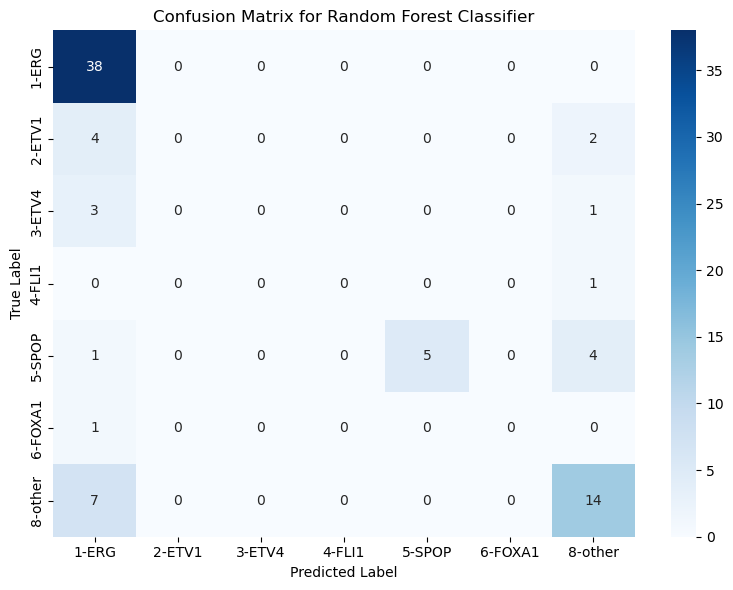

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # For potential numpy operations later

# --- IMPORTANT: Path to your wide data file ---
input_wide_data_path = 'C:/Users/Admin/Desktop/Output Final.csv' # This file was uploaded in the current session

try:
    # 1. Load the Wide Data with labels.csv file
    df_wide_data = pd.read_csv(input_wide_data_path)
    print(f"Successfully loaded '{input_wide_data_path}'. Shape: {df_wide_data.shape}")

    # Ensure PATIENT_ID is set as index if it's not already, then drop it from features
    if 'PATIENT_ID' in df_wide_data.columns:
        df_wide_data.set_index('PATIENT_ID', inplace=True)
        print("Set 'PATIENT_ID' as DataFrame index.")

    # 2. Separate Features (X) and Target (y)
    if 'Subtype' not in df_wide_data.columns:
        raise ValueError("Error: 'Subtype' column not found in the loaded DataFrame. Please ensure it exists.")

    X = df_wide_data.drop(columns=['Subtype']) # Features (genes)
    y = df_wide_data['Subtype']             # Target (Subtype subtypes)

    print(f"\nShape of features (X): {X.shape}")
    print(f"Shape of target (y): {y.shape}")
    print(f"Subtype Subtypes unique values: {y.unique()}")
    print(f"Subtype Subtypes distribution:\n{y.value_counts()}")

    # 3. Data Preprocessing (Scaling)
    print("\nScaling gene expression data using StandardScaler...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Convert scaled numpy array back to DataFrame with original gene names and index
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    print("Scaling complete.")

    # 4. Handle Categorical Target (y)
    # Convert string labels (Subtype subtypes) to numerical labels for the classifier
    print("\nEncoding Subtype Subtype labels...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    # Store the mapping for inverse transformation later (to get original names)
    subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"Original Subtypes to Encoded Labels: {subtype_mapping}")
    print(f"Encoded target labels (y_encoded) shape: {y_encoded.shape}")
    
    
    

    # 5. Split Data into Training and Testing Sets
    # Using 80% for training and 20% for testing
    # stratify=y_encoded ensures that the proportion of subtypes is the same in train and test sets
    # random_state for reproducibility
    print("\nSplitting data into training and testing sets (80% train, 20% test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_df, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

    # 6. Initialize and Train Random Forest Classifier
    print("\nInitializing and training Random Forest Classifier...")
    # n_estimators: number of trees in the forest
    # random_state: for reproducibility
    # class_weight='balanced' can be useful for imbalanced classes (if any)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)
    print("Random Forest Classifier training complete.")

    # 7. Make Predictions
    print("\nMaking predictions on the test set...")
    y_pred = rf_classifier.predict(X_test)
    print("Predictions made.")

    # 8. Evaluate Model Performance
    print("\n--- Model Evaluation ---")
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    # Use target_names to get the original subtype names in the report
    target_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
   

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix for Random Forest Classifier')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_wide_data_path}' was not found. Please ensure it's in the same directory as the script.")
except ValueError as e:
    print(f"Data Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data loaded and Random Forest model re-trained for SHAP analysis.

--- Performing SHAP Analysis ---
Calculating SHAP values for the test set (this may take a few minutes)...
SHAP values calculation complete.

Generating SHAP Summary Bar Plot (overall feature importance)...


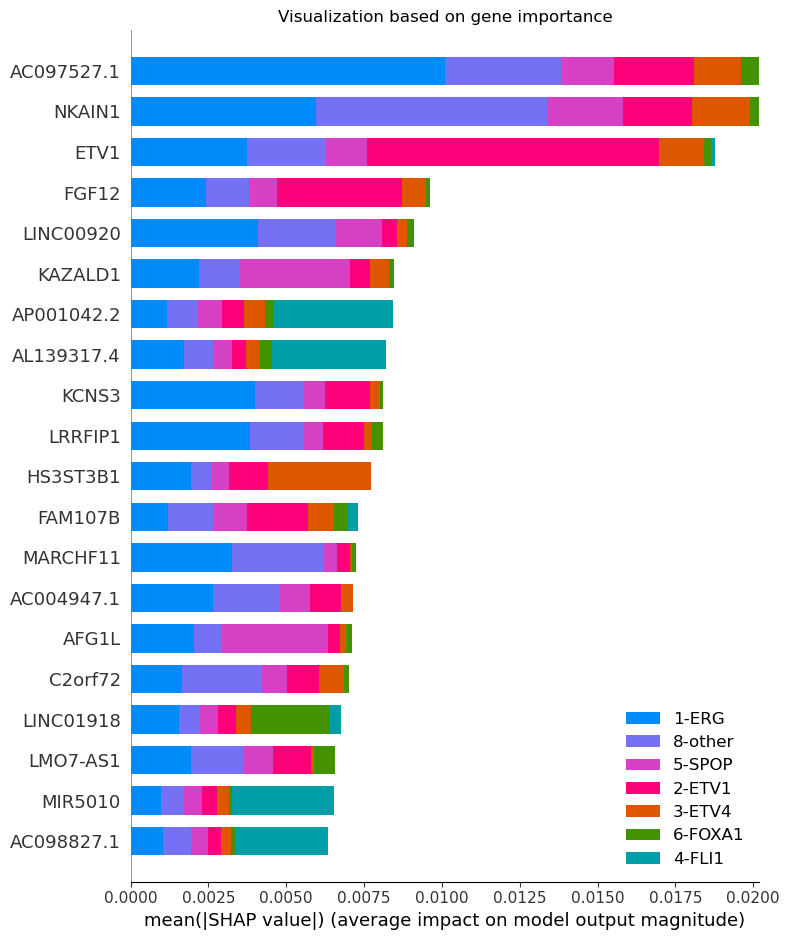


Generating SHAP Summary Dot Plot (feature impact and direction)...

SHAP plots generated. Please review the images to understand gene importance.


<Figure size 1200x1000 with 0 Axes>

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# No need for metrics imports for this step, but keeping for context if run independently.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import shap # Import the SHAP library

# --- IMPORTANT: Path to your wide data file ---
input_wide_data_path = 'C:/Users/Admin/Desktop/Output Final.csv' # This file was uploaded in the current session

try:
    # Re-load data and re-train model for reproducibility if script is run in parts
    # In a continuous session, X_scaled_df, y_encoded, X_train, X_test, y_train, y_test, rf_classifier, label_encoder would already be in memory.

    df_wide_data = pd.read_csv(input_wide_data_path)
    if 'PATIENT_ID' in df_wide_data.columns:
        df_wide_data.set_index('PATIENT_ID', inplace=True)

    X = df_wide_data.drop(columns=['Subtype'])
    y = df_wide_data['Subtype']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Store the mapping for inverse transformation later (to get original names)
    subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)

    print("Data loaded and Random Forest model re-trained for SHAP analysis.")

    # --- SHAP Analysis ---
    print("\n--- Performing SHAP Analysis ---")

    # 1. Initialize SHAP Explainer
    # Use TreeExplainer for tree-based models like Random Forest
    # The model expects raw features (X_scaled_df here)
    explainer = shap.TreeExplainer(rf_classifier)

    # 2. Compute SHAP values
    # Calculate SHAP values for the test set.
    # This might take a moment due to the large number of features.
    print("Calculating SHAP values for the test set (this may take a few minutes)...")
    shap_values = explainer.shap_values(X_test)
    print("SHAP values calculation complete.")

    # Convert shap_values to a list of arrays for multi-output case if needed
    # For multiclass, shap_values is a list of arrays, one for each class.
    # We want to see overall importance across all classes, so we can average the absolute SHAP values.
    # Alternatively, for overall feature importance, you can use shap.summary_plot(..., plot_type='bar')

    # Get the feature names
    feature_names = X.columns.tolist()

    # Get original class names for plotting
    class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

    # --- 3. Summarize SHAP values for overall feature importance ---

    # Option A: Summary Bar Plot (Overall feature importance across all classes)
    # This plots the mean absolute SHAP value for each feature.
    print("\nGenerating SHAP Summary Bar Plot (overall feature importance)...")
    plt.figure(figsize=(10, 8))
    # For multiclass classification, shap_values is a list of arrays (one for each class).
    # We can pass the list directly to summary_plot, and it will average across classes for the bar plot.
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                      plot_type="bar", class_names=class_names, show=False)
    plt.title('Visualization based on gene importance')
    plt.tight_layout()
    plt.show()

    # Option B: Summary Dot Plot (Individual feature contributions and direction)
    # This shows how each feature impacts the prediction for each sample.
    print("\nGenerating SHAP Summary Dot Plot (feature impact and direction)...")
    plt.figure(figsize=(12, 10))
   

    print("\nSHAP plots generated. Please review the images to understand gene importance.")

except FileNotFoundError:
    print(f"Error: The file '{input_wide_data_path}' was not found.")
except ImportError:
    print("\nError: The 'shap' library is not installed.")
    print("Please install it by running: pip install shap")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [1]:
#Saving necessary components before Streamlit operations

In [1]:
import joblib
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# --- Re-load data and re-train model for robustness/reproducibility in this isolated block ---
# (As explained previously, if running sequentially, these objects are already in memory)
input_wide_data_path = 'C:/Users/Admin/Desktop/Output Final.csv'

try:
    df_wide_data = pd.read_csv(input_wide_data_path)
    if 'PATIENT_ID' in df_wide_data.columns:
        df_wide_data.set_index('PATIENT_ID', inplace=True)

    X = df_wide_data.drop(columns=['Subtype'])
    y = df_wide_data['Subtype']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)

    # --- Save the trained model and preprocessors ---
    # Define a directory to save the models
    models_dir = 'trained_models'
    os.makedirs(models_dir, exist_ok=True) # Create the directory if it doesn't exist

    model_path = os.path.join(models_dir, 'random_forest_model.joblib')
    scaler_path = os.path.join(models_dir, 'scaler.joblib')
    encoder_path = os.path.join(models_dir, 'label_encoder.joblib')
    
    # Save a list of all original gene names, in the correct order, for consistent input
    gene_names_path = os.path.join(models_dir, 'gene_names.joblib')


    joblib.dump(rf_classifier, model_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(label_encoder, encoder_path)
    joblib.dump(X.columns.tolist(), gene_names_path) # Save the ordered list of all gene names

    print(f"\nModel saved to: {model_path}")
    print(f"Scaler saved to: {scaler_path}")
    print(f"Label Encoder saved to: {encoder_path}")
    print(f"All gene names saved to: {gene_names_path}")
    print("\nAll necessary components have been saved successfully.")

except Exception as e:
    print(f"An error occurred during saving components: {e}")


Model saved to: trained_models\random_forest_model.joblib
Scaler saved to: trained_models\scaler.joblib
Label Encoder saved to: trained_models\label_encoder.joblib
All gene names saved to: trained_models\gene_names.joblib

All necessary components have been saved successfully.


In [1]:
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import os
import shap
import matplotlib.pyplot as plt # Needed for SHAP waterfall plots

# --- Streamlit UI Setup ---
st.set_page_config(page_title="Cancer Subtype Predictor", layout="wide")
st.title("Cancer Subtype Prediction from Gene Expression")
st.markdown("Upload a CSV for molecular subtype prediction (Subtype classification).")

# --- Model & Preprocessor Loading (Cached) ---
@st.cache_resource
def load_model_components():
    models_dir = 'trained_models'
    try:
        model = joblib.load(os.path.join(models_dir, 'random_forest_model.joblib'))
        scaler = joblib.load(os.path.join(models_dir, 'scaler.joblib'))
        label_encoder = joblib.load(os.path.join(models_dir, 'label_encoder.joblib'))
        gene_names = joblib.load(os.path.join(models_dir, 'gene_names.joblib'))
        return model, scaler, label_encoder, gene_names
    except FileNotFoundError as e:
        st.error(f"Error loading model components: {e}. Check 'trained_models' folder.")
        st.stop()
    except Exception as e:
        st.error(f"An unexpected error occurred loading model: {e}.")
        st.stop()

# Load components
model, scaler, label_encoder, training_gene_names = load_model_components()

# --- Instructions for Upload ---
st.info("""
    **CSV Upload Instructions:**
    - Gene expression data in CSV format.
    - Rows: Samples, Columns: Genes.
    - Gene names (column headers) must match model's training genes.
""")

uploaded_file = st.file_uploader("Upload your CSV file", type="csv")

if uploaded_file is not None:
    try:
        input_df = pd.read_csv(uploaded_file)
        st.write("Preview:")
        st.dataframe(input_df.head())

        # --- Data Preparation ---
        processed_input_data = pd.DataFrame(0.0, index=input_df.index, columns=training_gene_names)
        common_genes = list(set(input_df.columns) & set(training_gene_names))
        processed_input_data[common_genes] = input_df[common_genes]

        st.write("### Scaling Data...")
        scaled_input = scaler.transform(processed_input_data)
        scaled_input_df = pd.DataFrame(scaled_input, columns=training_gene_names, index=input_df.index)
        st.write("Scaling complete.")

        st.write("### Making Predictions...")
        predictions_encoded = model.predict(scaled_input)
        predictions_subtype = label_encoder.inverse_transform(predictions_encoded)

        prediction_df = pd.DataFrame({
            'PATIENT_ID': input_df.index,
            'Predicted_Subtype': predictions_subtype
        })
        prediction_df.set_index('PATIENT_ID', inplace=True)
        st.write("### Prediction Results:")
        st.dataframe(prediction_df)

        # --- SHAP Explanation (Optional) ---
        st.write("### SHAP Explanation (Optional)")
        if st.checkbox("Show SHAP explanation for the first sample?", value=False):
            # Assuming 'model' is a sklearn tree-based model like RandomForestClassifier
            try:
                explainer = shap.TreeExplainer(model)
                single_sample_scaled = scaled_input_df.iloc[[0]]
                shap_values_single = explainer.shap_values(single_sample_scaled)

                predicted_class_index = predictions_encoded[0]
                predicted_class_name = label_encoder.inverse_transform([predicted_class_index])[0]

                st.write(f"Explanation for sample: `{single_sample_scaled.index[0]}` (Predicted: `{predicted_class_name}`)")

                if isinstance(shap_values_single, list): # Multiclass output
                    st.subheader(f"Influence for '{predicted_class_name}' subtype")
                    st_shap(shap.force_plot(
                        explainer.expected_value[predicted_class_index],
                        shap_values_single[predicted_class_index][0,:],
                        single_sample_scaled.iloc[0,:],
                        feature_names=training_gene_names,
                        matplotlib=False
                    ))
                    
                    st.subheader(f"Waterfall Plot for '{predicted_class_name}' subtype")
                    shap.plots.waterfall(shap.Explanation(
                        values=shap_values_single[predicted_class_index][0,:],
                        base_values=explainer.expected_value[predicted_class_index],
                        data=single_sample_scaled.iloc[0,:],
                        feature_names=training_gene_names
                    ), show=False)
                    st.pyplot(plt.gcf())
                else: # Binary output (less common for subtypes but robust)
                    st_shap(shap.force_plot(
                        explainer.expected_value,
                        shap_values_single[0,:],
                        single_sample_scaled.iloc[0,:],
                        feature_names=training_gene_names,
                        matplotlib=False
                    ))
                    
                    st.subheader(f"Waterfall Plot")
                    shap.plots.waterfall(shap.Explanation(
                        values=shap_values_single[0,:],
                        base_values=explainer.expected_value,
                        data=single_sample_scaled.iloc[0,:],
                        feature_names=training_gene_names
                    ), show=False)
                    st.pyplot(plt.gcf())

            except Exception as e:
                st.error(f"Could not generate SHAP explanation: {e}.")
                st.write("Ensure sample data is suitable for SHAP calculation.")

    except pd.errors.EmptyDataError:
        st.error("Uploaded CSV file is empty. Please upload data.")
    except Exception as e:
        st.error(f"An error occurred during processing: {e}. Check CSV format.")

# --- Custom SHAP Renderer ---
def st_shap(plot, height=None):
    shap_html = f"<head>{shap.getjs()}</head><body>{plot.html()}</body>"
    st.components.v1.html(shap_html, height=height)

2025-06-14 21:10:21.526 
  command:

    streamlit run c:\Users\Admin\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


TypeError: cannot unpack non-iterable NoneType object

In [2]:
pip install joblib



SyntaxError: invalid syntax (2104635791.py, line 1)

In [3]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.
